Project1

In [18]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import wavfile
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
#Control on the frequencies of the wav files of the dataset
frequencies = {}
signal_lengths = {}
folders = os.listdir('./audio_files')
for folder in tqdm(folders):
    entries = os.listdir('./audio_files'+'/'+folder)
    for entry in entries:    
        fs, signal = wavfile.read('./audio_files'+'/'+folder+'/'+entry)
        if len(signal) in signal_lengths:
            signal_lengths[len(signal)]+=1
        else:
            signal_lengths[len(signal)]=1
        if fs in frequencies.keys():
            frequencies[fs]+=1
        else:
            frequencies[fs]=1

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [00:17<00:00,  1.73it/s]C:\Users\Fede\AppData\Roaming\Python\Python36\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:17<00:00,  1.76it/s]


Perfect: all wav files have the same frequence: 



In [46]:
x = []
y = []
for i in signal_lengths:
    x.append(i)
    y.append(signal_lengths[i])
tot = 0
for i in range(81):
    tot = tot + y[i]
freq = []
counts = []
for j in frequencies:
    freq.append(str(j)+'Hz')
    counts.append(frequencies[j])
        
labels = []
values = []
one_second = 0
less = 0
more = 0

for i in range(len(x)):
    if x[i]==16000:
        one_second+=y[i]
    elif x[i]<16000:
        less+=y[i]
    else:
        more+=y[i]
labels.append('=1 second')
values.append(one_second/tot*100)
labels.append('<1 second')
values.append(less/tot*100)
labels.append('>1 second')
values.append(more/tot*100)
fig = make_subplots(rows=1, cols=2,specs=[[{"type": "domain"},{"type": "domain"}]],
                    subplot_titles=['Duration wav files', 'Frequency'])
fig.add_trace(go.Pie(labels=labels, values=values),row=1,col=1)
fig.add_trace(go.Pie(labels=freq, values=counts),row=1,col=2)
fig.update_layout(height=400, width=800)
fig.show()

In [56]:
lengths = []
frame_size = 0.025 #duration of a frame [s]
frame_stride = 0.01 #duration of the overlap between 2 consecutive frames [s]
folders = os.listdir('./audio_files')
k = 0
dataset = []
for folder in tqdm(folders):
    entries = os.listdir('./audio_files'+'/'+folder)
    for entry in entries:    
        fs, signal = wavfile.read('./audio_files'+'/'+folder+'/'+entry)
        frame_length, frame_step = frame_size*fs, frame_stride*fs
        signal_length = len(signal)
        frame_length = int(round(frame_length))
        frame_step = int(round(frame_step))
        num_frames = int(np.ceil(float(np.abs(signal_length-frame_length))/frame_step))
        NFFT=400
        
        pad_signal_length = num_frames*frame_step+frame_length
        z = np.zeros((pad_signal_length-signal_length))
        pad_signal = np.append(signal,z)
        
        indices = np.tile(np.arange(0,frame_length),(num_frames,1))+np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames = pad_signal[indices.astype(np.int32,copy=False)]
        frames *= np.hamming(frame_length)
        
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
        pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
        
        nfilt=40
        low_freq_mel = 0
        high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
        hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
        bin = np.floor((NFFT + 1) * hz_points / fs)
        
       
        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1])   # left
            f_m = int(bin[m])             # center
            f_m_plus = int(bin[m + 1])    # right

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
        filter_banks = 20 * np.log10(filter_banks)
        filter_banks -= (np.mean(filter_banks,axis=0)+1e-8)
        dataset.append(filter_banks)
        lengths.append(len(signal))

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [13:25<00:32, 32.63s/it]C:\Users\Fede\AppData\Roaming\Python\Python36\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [13:26<00:00, 23.15s/it]


[16000, 16000, 14861, 16000, 16000, 16000, 16000, 16000, 16000, 16000]


<Figure size 432x288 with 0 Axes>

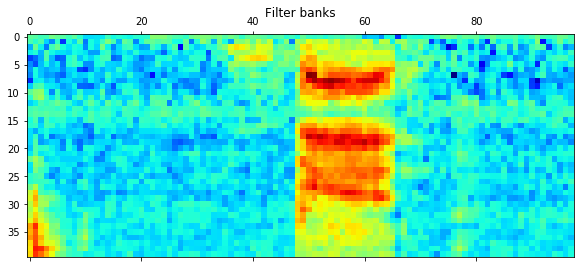

In [62]:
plt.figure()
plt.matshow(dataset[5].T,cmap=plt.cm.jet)
plt.title('Filter banks')
plt.show()

In [ ]:
y1 = []
y2 = []
for i in range(10000):
    if i>1000:
        y1.append(2595*np.log10(1+i/700))
    else:
        y1.append(i)
    y2.append(1000*np.log10(1+i/1000)/np.log10(2))
plt.plot(y1)    
plt.plot(y2)